In [1]:
# Importing necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set Matplotlib to display inline in the notebook
%matplotlib inline


# Function to identify if a stock has just come out of consolidation
def check_consolidation_breakout(ticker, period='1y', rolling_window=20, breakout_threshold=0.02):
    # Download historical data for the stock
    data = yf.download(ticker, period=period)
    
    # Step 1: Calculate rolling standard deviation to measure consolidation
    data['20d_std'] = data['Close'].rolling(window=rolling_window).std()

    # Step 2: Define consolidation as low volatility (low rolling std deviation)
    low_volatility_threshold = np.percentile(data['20d_std'].dropna(), 10)
    data['is_consolidating'] = data['20d_std'] < low_volatility_threshold

    # Step 3: Identify potential breakout by checking if price moves outside consolidation range
    data['20d_max'] = data['Close'].rolling(window=rolling_window).max()
    data['20d_min'] = data['Close'].rolling(window=rolling_window).min()

    # Step 4: Detect breakouts when price moves above or below the consolidation range
    data['breakout_up'] = (data['Close'] > data['20d_max'] * (1 + breakout_threshold)) & data['is_consolidating'].shift(1)
    data['breakout_down'] = (data['Close'] < data['20d_min'] * (1 - breakout_threshold)) & data['is_consolidating'].shift(1)

    # Return the data along with the breakout signals
    return data, data['breakout_up'].iloc[-1] or data['breakout_down'].iloc[-1]

# Input a list of stock tickers to scan
stock_list = input("Enter a list of stock tickers (comma-separated): ").split(',')
stock_list = [stock.strip().upper() for stock in stock_list]  # Clean and standardize the stock tickers

# Step 5: Scan the list of stocks for breakouts from consolidation
breakout_stocks = []
consolidation_data = {}

for stock in stock_list:
    stock_data, has_breakout = check_consolidation_breakout(stock)
    consolidation_data[stock] = stock_data  # Store the stock data for plotting later
    if has_breakout:
        breakout_stocks.append(stock)

# Output the stocks that have just come out of consolidation
if breakout_stocks:
    print("Stocks that have just come out of consolidation:")
    for i, stock in enumerate(breakout_stocks, 1):
        print(f"{i}. {stock}")
else:
    print("No stocks have just come out of consolidation.")


Enter a list of stock tickers (comma-separated):  LABU


[*********************100%***********************]  1 of 1 completed

No stocks have just come out of consolidation.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def detect_volatility_breakout(stock_symbol):
    # Step 1: Download stock data for the given symbol (1 year of daily data)
    stock_data = yf.download(stock_symbol, period='1y')

    # Step 2: Calculate 20-day rolling standard deviation (volatility)
    stock_data['20d_std'] = stock_data['Close'].rolling(window=20).std()

    # Step 3: Define the low-volatility threshold (10th percentile)
    low_volatility_threshold = np.percentile(stock_data['20d_std'].dropna(), 10)

    # Step 4: Identify low-volatility periods
    stock_data['low_volatility'] = stock_data['20d_std'] < low_volatility_threshold

    # Step 5: Detect breakouts - look for price increases after low-volatility period ends
    stock_data['price_change'] = stock_data['Close'].pct_change()  # Percent change of closing prices

    # Shift the low-volatility flag to see when a breakout occurs (when low-vol ends)
    stock_data['vol_breakout'] = (stock_data['low_volatility'].shift(1) == True) & (stock_data['low_volatility'] == False) & (stock_data['price_change'] > 0)

    # Find the last breakout (where vol_breakout is True)
    breakout_dates = stock_data[stock_data['vol_breakout']].index
    if len(breakout_dates) > 0:
        last_breakout_date = breakout_dates[-1]
    else:
        print(f"No breakouts found for {stock_symbol} in the last year.")
        return

    # Output the last breakout date and the corresponding closing price
    print(f"Last breakout date for {stock_symbol}: {last_breakout_date}")
    print(f"Closing price at breakout: {stock_data.loc[last_breakout_date, 'Close']}")

    # Step 6: Plot the stock price and mark the breakout point
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot closing price
    ax1.plot(stock_data['Close'], label=f'{stock_symbol} Closing Price', color='b')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Mark the last breakout point with a vertical line
    ax1.axvline(x=last_breakout_date, color='red', linestyle='--', label='Last Breakout')

    # Highlight low-volatility periods in the plot
    ax1.fill_between(stock_data.index, stock_data['Close'], where=stock_data['low_volatility'], color='lightgray', label='Low Volatility')

    # Step 7: Add the rolling volatility to the plot (secondary y-axis)
    ax2 = ax1.twinx()  # Create a second y-axis for volatility
    ax2.plot(stock_data['20d_std'], label='20-day Rolling Volatility', color='orange')
    ax2.set_ylabel('Volatility (20-day Std Dev)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Step 8: Add legends and title
    fig.suptitle(f'{stock_symbol} Stock Price and 20-Day Rolling Volatility with Low-Volatility Breakout', fontsize=16)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()

# Input: Enter a stock symbol (like 'MSFT', 'AAPL', etc.)
stock_symbol = input("Enter stock symbol: ").upper()
detect_volatility_breakout(stock_symbol)


In [ ]:
%matplotlib widget

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

def detect_volatility_breakout(stock_symbol):
    # Step 1: Download stock data for the given symbol (1 year of daily data)
    stock_data = yf.download(stock_symbol, period='1y')

    # Step 2: Calculate 20-day rolling standard deviation (volatility)
    stock_data['20d_std'] = stock_data['Close'].rolling(window=20).std()

    # Step 3: Define the low-volatility threshold (10th percentile)
    low_volatility_threshold = np.percentile(stock_data['20d_std'].dropna(), 10)

    # Step 4: Identify low-volatility periods
    stock_data['low_volatility'] = stock_data['20d_std'] < low_volatility_threshold

    # Step 5: Detect breakouts - look for price increases after low-volatility period ends
    stock_data['price_change'] = stock_data['Close'].pct_change()  # Percent change of closing prices

    # Shift the low-volatility flag to see when a breakout occurs (when low-vol ends)
    stock_data['vol_breakout'] = (stock_data['low_volatility'].shift(1) == True) & (stock_data['low_volatility'] == False) & (stock_data['price_change'] > 0)

    # Find the last breakout (where vol_breakout is True)
    breakout_dates = stock_data[stock_data['vol_breakout']].index
    if len(breakout_dates) > 0:
        last_breakout_date = breakout_dates[-1]
    else:
        print(f"No breakouts found for {stock_symbol} in the last year.")
        return

    # Output the last breakout date and the corresponding closing price
    print(f"Last breakout date for {stock_symbol}: {last_breakout_date}")
    print(f"Closing price at breakout: {stock_data.loc[last_breakout_date, 'Close']}")

    # Step 6: Create subplots (2 rows: stock price in upper pane, volatility in lower pane)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Step 7: Plot the stock closing price on the first pane (ax1)
    ax1.plot(stock_data['Close'], label=f'{stock_symbol} Closing Price', color='b')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.axvline(x=last_breakout_date, color='red', linestyle='--', label='Last Breakout')
    ax1.fill_between(stock_data.index, stock_data['Close'], where=stock_data['low_volatility'], color='lightgray', label='Low Volatility')
    ax1.legend(loc='upper left')

    # Step 8: Plot the rolling volatility in the lower pane (ax2)
    ax2.plot(stock_data['20d_std'], label='20-day Rolling Volatility', color='orange')
    ax2.set_ylabel('Volatility (20-day Std Dev)', color='orange')
    ax2.set_xlabel('Date')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.legend(loc='upper left')

    # Step 9: Add title to the figure
    fig.suptitle(f'{stock_symbol} Stock Price and 20-Day Rolling Volatility', fontsize=16)

    # Step 10: Add crosshair cursor to both subplots
    cursor1 = Cursor(ax1, useblit=True, color='red', linewidth=1)
    cursor2 = Cursor(ax2, useblit=True, color='red', linewidth=1)

    # Step 11: Show the plot with a crosshair
    plt.tight_layout()
    plt.show()

# Input: Enter a stock symbol (like 'MSFT', 'AAPL', etc.)
stock_symbol = input("Enter stock symbol: ").upper()
detect_volatility_breakout(stock_symbol)


In [ ]:
# If using JupyterLab, you can still try `%matplotlib widget`, or `%matplotlib inline` for static output
%matplotlib widget

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcursors

def detect_volatility_breakout(stock_symbol):
    # Step 1: Download stock data for the given symbol (1 year of daily data)
    stock_data = yf.download(stock_symbol, period='1y')

    # Step 2: Calculate 20-day rolling standard deviation (volatility)
    stock_data['20d_std'] = stock_data['Close'].rolling(window=20).std()

    # Step 3: Define the low-volatility threshold (10th percentile)
    low_volatility_threshold = np.percentile(stock_data['20d_std'].dropna(), 10)

    # Step 4: Identify low-volatility periods
    stock_data['low_volatility'] = stock_data['20d_std'] < low_volatility_threshold

    # Step 5: Detect breakouts - look for price increases after low-volatility period ends
    stock_data['price_change'] = stock_data['Close'].pct_change()  # Percent change of closing prices

    # Shift the low-volatility flag to see when a breakout occurs (when low-vol ends)
    stock_data['vol_breakout'] = (stock_data['low_volatility'].shift(1) == True) & (stock_data['low_volatility'] == False) & (stock_data['price_change'] > 0)

    # Find the last breakout (where vol_breakout is True)
    breakout_dates = stock_data[stock_data['vol_breakout']].index
    if len(breakout_dates) > 0:
        last_breakout_date = breakout_dates[-1]
    else:
        print(f"No breakouts found for {stock_symbol} in the last year.")
        return

    # Output the last breakout date and the corresponding closing price
    print(f"Last breakout date for {stock_symbol}: {last_breakout_date}")
    print(f"Closing price at breakout: {stock_data.loc[last_breakout_date, 'Close']}")

    # Step 6: Create subplots (2 rows: stock price in upper pane, volatility in lower pane)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Step 7: Plot the stock closing price on the first pane (ax1)
    ax1.plot(stock_data['Close'], label=f'{stock_symbol} Closing Price', color='b')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.axvline(x=last_breakout_date, color='red', linestyle='--', label='Last Breakout')
    ax1.fill_between(stock_data.index, stock_data['Close'], where=stock_data['low_volatility'], color='lightgray', label='Low Volatility')
    ax1.legend(loc='upper left')

    # Step 8: Plot the rolling volatility in the lower pane (ax2)
    ax2.plot(stock_data['20d_std'], label='20-day Rolling Volatility', color='orange')
    ax2.set_ylabel('Volatility (20-day Std Dev)', color='orange')
    ax2.set_xlabel('Date')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.legend(loc='upper left')

    # Step 9: Add title to the figure
    fig.suptitle(f'{stock_symbol} Stock Price and 20-Day Rolling Volatility', fontsize=16)

    # Step 10: Use mplcursors to add interactive crosshair
    mplcursors.cursor(hover=True)

    # Step 11: Show the plot with the crosshair functionality
    plt.tight_layout()
    plt.show()

# Input: Enter a stock symbol (like 'MSFT', 'AAPL', etc.)
stock_symbol = input("Enter stock symbol: ").upper()
detect_volatility_breakout(stock_symbol)


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def detect_volatility_breakout(stock_symbol):
    # Step 1: Download stock data for the given symbol (1 year of daily data)
    stock_data = yf.download(stock_symbol, period='1y')

    # Step 2: Calculate 20-day rolling standard deviation (volatility)
    stock_data['20d_std'] = stock_data['Close'].rolling(window=20).std()

    # Step 3: Define the low-volatility threshold (10th percentile)
    low_volatility_threshold = np.percentile(stock_data['20d_std'].dropna(), 10)

    # Step 4: Identify low-volatility periods
    stock_data['low_volatility'] = stock_data['20d_std'] < low_volatility_threshold

    # Step 5: Detect breakouts - look for price increases after low-volatility period ends
    stock_data['price_change'] = stock_data['Close'].pct_change()  # Percent change of closing prices
    stock_data['vol_breakout'] = (stock_data['low_volatility'].shift(1) == True) & (stock_data['low_volatility'] == False) & (stock_data['price_change'] > 0)

    # Find the last breakout (where vol_breakout is True)
    breakout_dates = stock_data[stock_data['vol_breakout']].index
    if len(breakout_dates) > 0:
        last_breakout_date = breakout_dates[-1]
    else:
        print(f"No breakouts found for {stock_symbol} in the last year.")
        return

    # Output the last breakout date and the corresponding closing price
    print(f"Last breakout date for {stock_symbol}: {last_breakout_date}")
    print(f"Closing price at breakout: {stock_data.loc[last_breakout_date, 'Close']}")

    # Step 6: Create subplots (2 rows: stock price in upper pane, volatility in lower pane)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Step 7: Plot the stock closing price on the first pane (ax1)
    ax1.plot(stock_data['Close'], label=f'{stock_symbol} Closing Price', color='b')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.axvline(x=last_breakout_date, color='red', linestyle='--', label='Last Breakout')
    ax1.fill_between(stock_data.index, stock_data['Close'], where=stock_data['low_volatility'], color='lightgray', label='Low Volatility')
    ax1.legend(loc='upper left')

    # Step 8: Plot the rolling volatility in the lower pane (ax2)
    ax2.plot(stock_data['20d_std'], label='20-day Rolling Volatility', color='orange')

    # Step 9: Highlight peaks and bottoms in volatility
    # Finding local maxima and minima
    local_max_indices = argrelextrema(stock_data['20d_std'].values, np.greater, order=5)[0]
    local_min_indices = argrelextrema(stock_data['20d_std'].values, np.less, order=5)[0]

    # Plot peaks and troughs
    ax2.scatter(stock_data.index[local_max_indices], stock_data['20d_std'].iloc[local_max_indices], color='red', marker='o', label='Peaks')
    ax2.scatter(stock_data.index[local_min_indices], stock_data['20d_std'].iloc[local_min_indices], color='green', marker='o', label='Troughs')

    ax2.set_ylabel('Volatility (20-day Std Dev)', color='orange')
    ax2.set_xlabel('Date')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.legend(loc='upper left')

    # Step 10: Add title to the figure
    fig.suptitle(f'{stock_symbol} Stock Price and 20-Day Rolling Volatility', fontsize=16)

    # Step 11: Show the plot with the highlighted peaks and troughs
    plt.tight_layout()
    plt.show()

# Input: Enter a stock symbol (like 'MSFT', 'AAPL', etc.)
stock_symbol = input("Enter stock symbol: ").upper()
detect_volatility_breakout(stock_symbol)


Enter stock symbol:  labu


[*********************100%***********************]  1 of 1 completed


Last breakout date for LABU: 2024-07-11 00:00:00
Closing price at breakout: 132.6199951171875


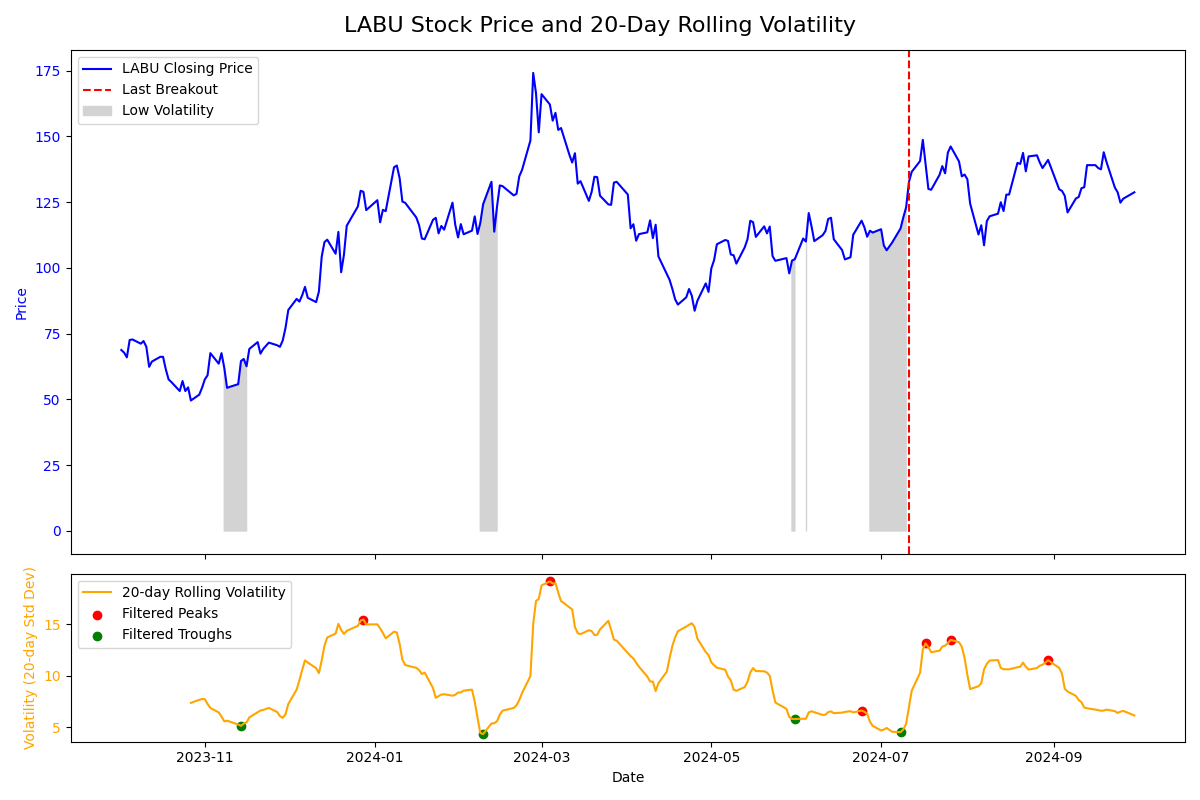

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def detect_volatility_breakout(stock_symbol, min_difference=0.02):
    # Step 1: Download stock data for the given symbol (1 year of daily data)
    stock_data = yf.download(stock_symbol, period='1y')

    # Step 2: Calculate 20-day rolling standard deviation (volatility)
    stock_data['20d_std'] = stock_data['Close'].rolling(window=20).std()

    # Step 3: Define the low-volatility threshold (10th percentile)
    low_volatility_threshold = np.percentile(stock_data['20d_std'].dropna(), 10)

    # Step 4: Identify low-volatility periods
    stock_data['low_volatility'] = stock_data['20d_std'] < low_volatility_threshold

    # Step 5: Detect breakouts - look for price increases after low-volatility period ends
    stock_data['price_change'] = stock_data['Close'].pct_change()  # Percent change of closing prices
    stock_data['vol_breakout'] = (stock_data['low_volatility'].shift(1) == True) & (stock_data['low_volatility'] == False) & (stock_data['price_change'] > 0)

    # Find the last breakout (where vol_breakout is True)
    breakout_dates = stock_data[stock_data['vol_breakout']].index
    if len(breakout_dates) > 0:
        last_breakout_date = breakout_dates[-1]
    else:
        print(f"No breakouts found for {stock_symbol} in the last year.")
        return

    # Output the last breakout date and the corresponding closing price
    print(f"Last breakout date for {stock_symbol}: {last_breakout_date}")
    print(f"Closing price at breakout: {stock_data.loc[last_breakout_date, 'Close']}")

    # Step 6: Create subplots (2 rows: stock price in upper pane, volatility in lower pane)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Step 7: Plot the stock closing price on the first pane (ax1)
    ax1.plot(stock_data['Close'], label=f'{stock_symbol} Closing Price', color='b')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.axvline(x=last_breakout_date, color='red', linestyle='--', label='Last Breakout')
    ax1.fill_between(stock_data.index, stock_data['Close'], where=stock_data['low_volatility'], color='lightgray', label='Low Volatility')
    ax1.legend(loc='upper left')

    # Step 8: Plot the rolling volatility in the lower pane (ax2)
    ax2.plot(stock_data['20d_std'], label='20-day Rolling Volatility', color='orange')

    # Step 9: Highlight peaks and bottoms in volatility
    # Finding local maxima and minima
    local_max_indices = argrelextrema(stock_data['20d_std'].values, np.greater, order=5)[0]
    local_min_indices = argrelextrema(stock_data['20d_std'].values, np.less, order=5)[0]

    # Step 10: Filter peaks and troughs based on the difference
    filtered_max_indices = []
    filtered_min_indices = []

    # Filter local maxima
    for i in range(1, len(local_max_indices)):
        if (stock_data['20d_std'].iloc[local_max_indices[i]] - stock_data['20d_std'].iloc[local_max_indices[i - 1]]) > min_difference:
            filtered_max_indices.append(local_max_indices[i])
    
    # Always include the first local maximum
    if len(local_max_indices) > 0:
        filtered_max_indices.insert(0, local_max_indices[0])
    
    # Filter local minima
    for i in range(1, len(local_min_indices)):
        if (stock_data['20d_std'].iloc[local_min_indices[i - 1]] - stock_data['20d_std'].iloc[local_min_indices[i]]) > min_difference:
            filtered_min_indices.append(local_min_indices[i])
    
    # Always include the first local minimum
    if len(local_min_indices) > 0:
        filtered_min_indices.insert(0, local_min_indices[0])

    # Plot filtered peaks and troughs
    ax2.scatter(stock_data.index[filtered_max_indices], stock_data['20d_std'].iloc[filtered_max_indices], color='red', marker='o', label='Filtered Peaks')
    ax2.scatter(stock_data.index[filtered_min_indices], stock_data['20d_std'].iloc[filtered_min_indices], color='green', marker='o', label='Filtered Troughs')

    ax2.set_ylabel('Volatility (20-day Std Dev)', color='orange')
    ax2.set_xlabel('Date')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.legend(loc='upper left')

    # Step 11: Add title to the figure
    fig.suptitle(f'{stock_symbol} Stock Price and 20-Day Rolling Volatility', fontsize=16)

    # Step 12: Show the plot with the highlighted peaks and troughs
    plt.tight_layout()
    plt.show()

# Input: Enter a stock symbol (like 'MSFT', 'AAPL', etc.)
stock_symbol = input("Enter stock symbol: ").upper()
detect_volatility_breakout(stock_symbol)


Enter stock symbol:  spy


[*********************100%***********************]  1 of 1 completed


[  29   50   70   83  131  159  185  196  210  227  255  271  314  338
  356  378  405  435  455  461  475  495  514  545  559  576  600  620
  639  674  704  731  747  770  784  791  804  828  852  864  878  900
  912  949  969  984  999 1019 1057 1080 1104 1114 1124 1137 1157 1181
 1196 1209 1225 1245]
[  24   34   62   78  119  137  158  174  203  223  233  248  264  291
  329  352  370  388  425  449  470  486  504  530  566  586  613  631
  659  688  718  740  757  778  788  798  817  841  860  867  885  904
  916  935  957  979 1010 1044 1067 1089 1098 1109 1118 1131 1146 1168
 1188 1205 1221 1237]
days since last trough: 13 
days since last peak: 21 
[   1   44   84  103  119  126  139  147  155  175  186  205  236  247
  274  289  304  310  317  326  335  358  372  406  421  432  452  462
  474  497  506  533  547  560  586  604  613  664  684  692  701  709
  738  756  764  780  790  803  811  817  831  846  859  867  898  904
  912  918  939  976  990 1008 1026 1063 1072 1080

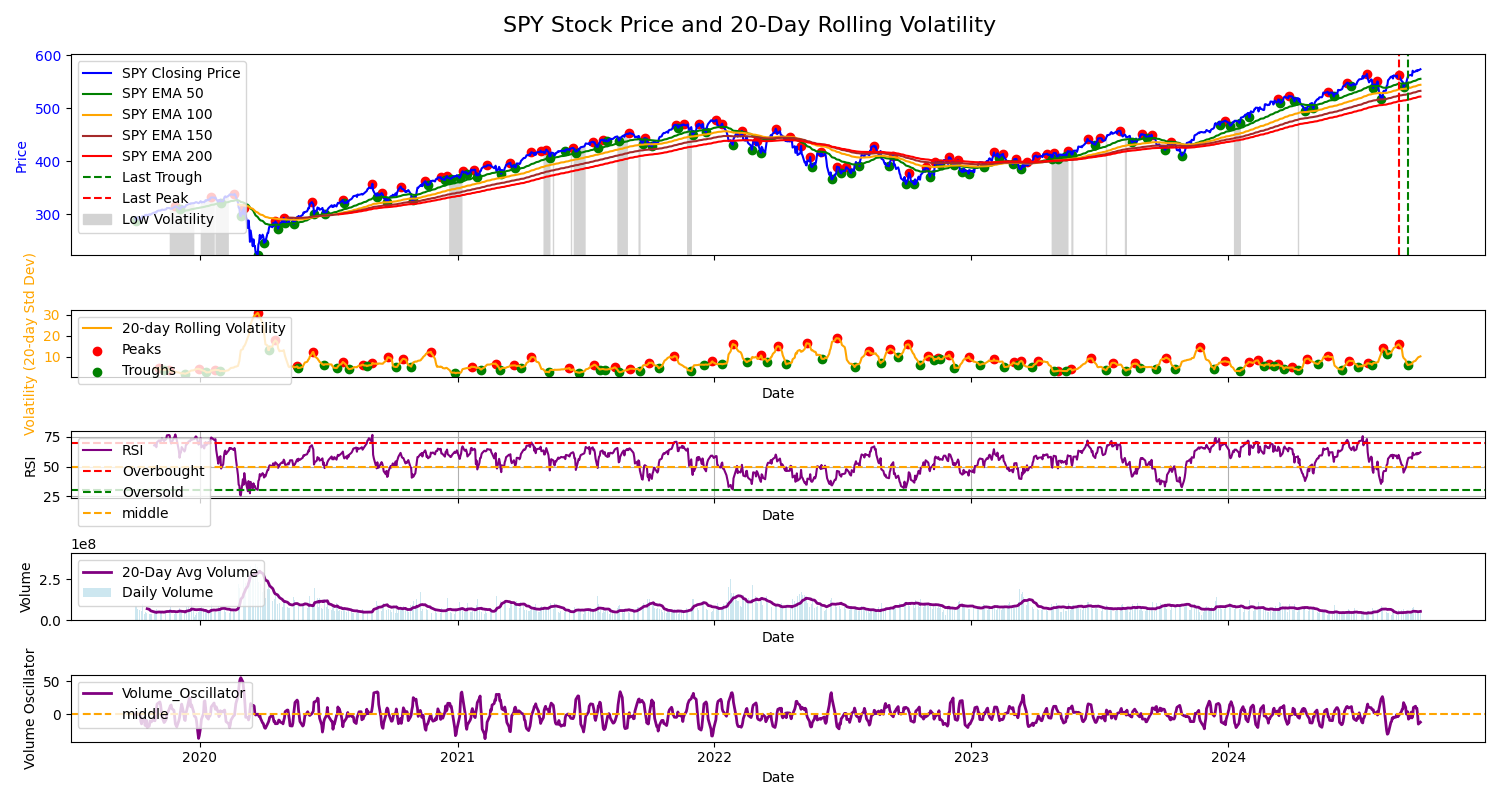

In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import MultiCursor as mplcursor
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from ta.utils import dropna
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
# from ta.volume import NegativeVolumeIndexIndicator

def calculate_profit(stock_symbol, local_max_indices, local_min_indices):
    # Calculate profit from trough to peak
    profits = []
    for trough_index in local_min_indices:
        # Buy price at trough
        buy_price = stock_data['Close'].iloc[trough_index]

        # Find the next peak after the trough
        for peak_index in local_max_indices:
            if peak_index > trough_index:
                # Sell price at peak
                sell_price = stock_data['Close'].iloc[peak_index]
                profit = sell_price - buy_price
                profits.append(profit)
                print(f"Buy at {buy_price:.2f} on {stock_data.index[trough_index].date()} and sell at {sell_price:.2f} on {stock_data.index[peak_index].date()}, Profit: {profit:.2f}")
                break  # Move to the next trough

    # Calculate total profit
    total_profit = sum(profits)
    print(f"\nTotal Profit from all trades: {total_profit:.2f}")   

def volume_oscillator(df, short_window=5, long_window=10):
    """
    Calculate the Volume Oscillator Index.

    Parameters:
    df (pd.DataFrame): DataFrame containing a 'Volume' column.
    short_window (int): The short period for the moving average.
    long_window (int): The long period for the moving average.

    Returns:
    pd.Series: The Volume Oscillator values.
    """
    # Calculate the short and long moving averages of the volume
    short_ma = df['Volume'].rolling(window=short_window, min_periods=1).mean()
    long_ma = df['Volume'].rolling(window=long_window, min_periods=1).mean()
    
    # Calculate the Volume Oscillator
    volume_oscillator = ((short_ma - long_ma) / long_ma) * 100  # As a percentage

    return volume_oscillator
    
def detect_volatility_breakout_and_profit(stock_symbol):
    # Step 1: Download stock data for the given symbol (1 year of daily data)
    stock_data = yf.download(stock_symbol, period='5y')

    # Step 2: Calculate 20-day rolling standard deviation (volatility)
    stock_data['20d_std'] = stock_data['Close'].rolling(window=20).std()

    # Step 3: Define the low-volatility threshold (10th percentile)
    low_volatility_threshold = np.percentile(stock_data['20d_std'].dropna(), 10)

    # Step 4: Identify low-volatility periods
    stock_data['low_volatility'] = stock_data['20d_std'] < low_volatility_threshold

    # Step 5: Detect breakouts
    stock_data['price_change'] = stock_data['Close'].pct_change()
    stock_data['vol_breakout'] = (stock_data['low_volatility'].shift(1) == True) & (stock_data['low_volatility'] == False) & (stock_data['price_change'] > 0)

    # Find peaks and troughs in volatility
    local_max_indices = argrelextrema(stock_data['20d_std'].values, np.greater, order=5)[0]
    local_min_indices = argrelextrema(stock_data['20d_std'].values, np.less, order=5)[0]
 
    # local_max_indices, _ = find_peaks(stock_data['20d_std'].values, prominence=1)
    # local_min_indices, _ = find_peaks(-stock_data['20d_std'].values, prominence=1)

    local_max_price_indices = argrelextrema(stock_data['Close'].values, np.greater, order=5)[0]
    local_min_price_indices = argrelextrema(stock_data['Close'].values, np.less, order=5)[0]

    rsi = RSIIndicator(stock_data['Close'], 20).rsi()

    ema50 = EMAIndicator(stock_data['Close'],50).ema_indicator()
    ema100 = EMAIndicator(stock_data['Close'],100).ema_indicator()
    ema150 = EMAIndicator(stock_data['Close'],150).ema_indicator()
    ema200 = EMAIndicator(stock_data['Close'],200).ema_indicator()
    
    stock_data['20d_avg_volume'] = stock_data['Volume'].rolling(window=14).mean()

    stock_data['Volume_Oscillator'] = volume_oscillator(stock_data)
    # stock_data['NVI'] = NegativeVolumeIndexIndicator(stock_data['Close'], stock_data['Volume']).negative_volume_index() 

    # Create subplots (2 rows: stock price in upper pane, volatility in lower pane)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1,1,1]})

    # Plot the stock closing price
    ax1.plot(stock_data['Close'], label=f'{stock_symbol} Closing Price', color='b')
    ax1.plot(ema50, label=f'{stock_symbol} EMA 50', color='green')
    ax1.plot(ema100, label=f'{stock_symbol} EMA 100', color='orange')
    ax1.plot(ema150, label=f'{stock_symbol} EMA 150', color='brown')
    ax1.plot(ema200, label=f'{stock_symbol} EMA 200', color='red')
    
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.axvline(x=stock_data.index[local_min_indices[-1]], color='green', linestyle='--', label='Last Trough')
    ax1.axvline(x=stock_data.index[local_max_indices[-1]], color='red', linestyle='--', label='Last Peak')
    ax1.fill_between(stock_data.index, stock_data['Close'], where=stock_data['low_volatility'], color='lightgray', label='Low Volatility')
    ax1.legend(loc='upper left')
    ax1.set_ylim(bottom=stock_data['Close'].min())

    # Plot peaks and troughs
    ax1.scatter(stock_data.index[local_max_price_indices], stock_data['Close'].iloc[local_max_price_indices], color='red', marker='o', label='Peaks')
    ax1.scatter(stock_data.index[local_min_price_indices], stock_data['Close'].iloc[local_min_price_indices], color='green', marker='o', label='Troughs')


    last_idx = len(stock_data)
    
    print(local_min_indices)
    print(local_max_indices)
    print('days since last trough: %d ' % (last_idx - local_min_indices[-1]))
    print('days since last peak: %d '% (last_idx - local_max_indices[-1]))

    print(local_min_price_indices)
    print(local_max_price_indices)
    print('days since last price trough: %d ' % (last_idx - local_min_price_indices[-1]))
    print('days since last price peak: %d '% (last_idx - local_max_price_indices[-1]))
  
    # Plot the rolling volatility
    ax2.plot(stock_data['20d_std'], label='20-day Rolling Volatility', color='orange')

    # Plot peaks and troughs
    ax2.scatter(stock_data.index[local_max_indices], stock_data['20d_std'].iloc[local_max_indices], color='red', marker='o', label='Peaks')
    ax2.scatter(stock_data.index[local_min_indices], stock_data['20d_std'].iloc[local_min_indices], color='green', marker='o', label='Troughs')

    ax2.set_ylabel('Volatility (20-day Std Dev)', color='orange')
    ax2.set_xlabel('Date')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.legend(loc='upper left')

    # Add title to the figure
    fig.suptitle(f'{stock_symbol} Stock Price and 20-Day Rolling Volatility', fontsize=16)

    ax3.plot(stock_data.index, rsi, label='RSI', color='purple')
    ax3.axhline(70, color='red', linestyle='--', label='Overbought')
    ax3.axhline(30, color='green', linestyle='--', label='Oversold')
    ax3.axhline(50, color='orange', linestyle='--', label='middle')
    ax3.set_ylabel('RSI')
    ax3.set_xlabel('Date')
    ax3.legend(loc='upper left')
    ax3.grid(True)

    # Plot the volume and 20-day average volume
    ax4.bar(stock_data.index, stock_data['Volume'], label='Daily Volume', color='lightblue', alpha=0.6)
    ax4.plot(stock_data.index, stock_data['20d_avg_volume'], label='20-Day Avg Volume', color='purple', linewidth=2)

    ax4.set_ylabel('Volume')
    ax4.set_xlabel('Date')
    ax4.legend(loc='upper left')

    # Plot the volume oscillator
    ax5.plot(stock_data.index, stock_data['Volume_Oscillator'], label='Volume_Oscillator', color='purple', linewidth=2)
    ax5.axhline(0, color='orange', linestyle='--', label='middle')
    ax5.set_ylabel('Volume Oscillator')
    ax5.set_xlabel('Date')
    ax5.legend(loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Input: Enter a stock symbol (like 'MSFT', 'AAPL', etc.)
user_input = input("Enter stock symbol: ").upper()
ticker_list = [ticker.strip() for ticker in user_input.split(',')]  # Process the input

for i, ticker in enumerate(ticker_list):
    detect_volatility_breakout_and_profit(ticker)
